In [7]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


In [8]:
df = pd.read_csv("../loan_dataset_20000.csv") 

X_raw = df.drop("loan_paid_back", axis=1)
y = df["loan_paid_back"]

# monthly and yearly income carry the same info monhly = yearly / 12
X_raw = X_raw.drop(columns=['monthly_income'])

X = X_raw.copy()
y = y.copy()

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [9]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

target_col = "loan_paid_back" 
X = df.drop(columns=[target_col])
y = df[target_col]

# stratify keeps the 0/1 ratio similar in train and test (important for FP/FN work)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("\nClass distribution (train):\n", y_train.value_counts(normalize=True))
print("\nClass distribution (test):\n", y_test.value_counts(normalize=True))


Train shapes: (16000, 21) (16000,)
Test shapes:  (4000, 21) (4000,)

Class distribution (train):
 loan_paid_back
1    0.799875
0    0.200125
Name: proportion, dtype: float64

Class distribution (test):
 loan_paid_back
1    0.8
0    0.2
Name: proportion, dtype: float64


In [10]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
pipeline_xgb = Pipeline([
    ('prep', preprocessor_tree),
    ('model', xgb)
])
pipeline_xgb.fit(X_train, y_train)

y_pred_xgb = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]


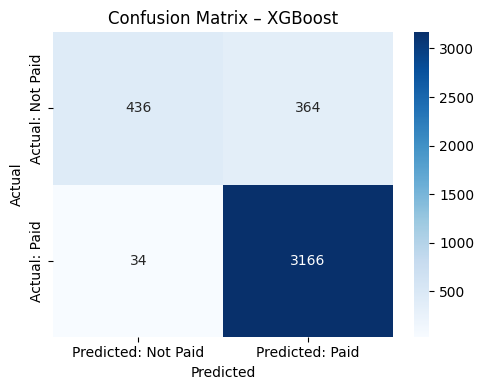

              precision    recall  f1-score   support

           0       0.93      0.55      0.69       800
           1       0.90      0.99      0.94      3200

    accuracy                           0.90      4000
   macro avg       0.91      0.77      0.81      4000
weighted avg       0.90      0.90      0.89      4000



In [11]:
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted: Not Paid', 'Predicted: Paid'],
    yticklabels=['Actual: Not Paid', 'Actual: Paid']
)
plt.title('Confusion Matrix – XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_xgb))


In [12]:
# 1) feature names after preprocessing (one-hot etc.)
prep = pipeline_xgb.named_steps["prep"]
feature_names = prep.get_feature_names_out()

# 2) xgboost booster
booster = pipeline_xgb.named_steps["model"].get_booster()

# 3) importance by gain
importance = booster.get_score(importance_type="gain")

# 4) print feature_name : importance
for f, value in sorted(importance.items(), key=lambda x: x[1], reverse=True):
    idx = int(f[1:])  # f30 -> 30
    print(f"{feature_names[idx]} : {value}")


cat__employment_status_Unemployed : 141.59027099609375
cat__employment_status_Student : 40.45380401611328
cat__employment_status_Self-employed : 31.741840362548828
cat__employment_status_Retired : 22.019737243652344
cat__employment_status_Employed : 16.629785537719727
cat__grade_subgrade_A1 : 10.391799926757812
num__debt_to_income_ratio : 7.114583969116211
num__credit_score : 6.694042205810547
cat__grade_subgrade_A2 : 6.6811676025390625
cat__grade_subgrade_B3 : 5.288813591003418
cat__grade_subgrade_E2 : 4.492387771606445
cat__grade_subgrade_F4 : 4.1194000244140625
cat__grade_subgrade_F1 : 3.9646823406219482
cat__grade_subgrade_B1 : 3.793278217315674
cat__grade_subgrade_E4 : 3.738612174987793
cat__grade_subgrade_E1 : 3.425260543823242
cat__grade_subgrade_C3 : 3.28879714012146
cat__grade_subgrade_D5 : 3.2448570728302
cat__grade_subgrade_F3 : 3.220536708831787
cat__gender_Other : 3.1922531127929688
cat__grade_subgrade_D2 : 3.130335807800293
cat__loan_purpose_Education : 3.0855629444122314

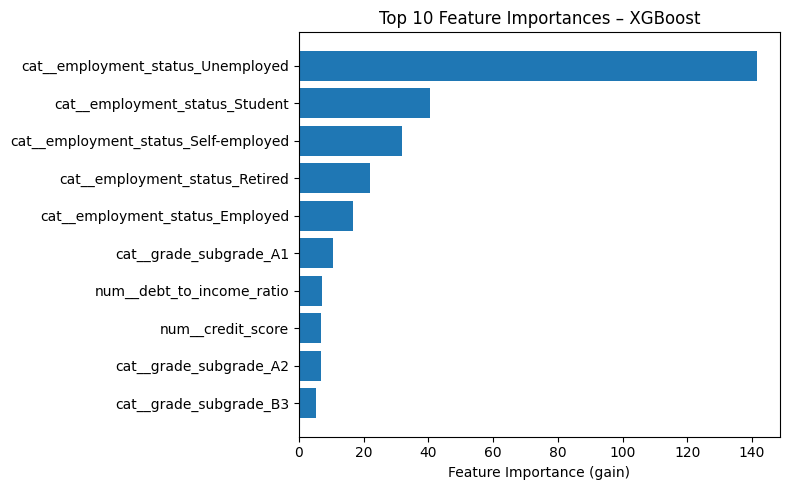

In [13]:
mapped = [
    (feature_names[int(f[1:])], value)
    for f, value in importance.items()
]

# sort by importance and take top 10
mapped_sorted = sorted(mapped, key=lambda x: x[1], reverse=True)[:10]

features, values = zip(*mapped_sorted)

# plot
plt.figure(figsize=(8, 5))
plt.barh(features, values)
plt.xlabel("Feature Importance (gain)")
plt.title("Top 10 Feature Importances – XGBoost")
plt.gca().invert_yaxis()  # most important on top
plt.tight_layout()
plt.show()